# Dimensionality Reduction
* Many ML problems and datasets invovle thousands or even millions of features
* The extremely large number of features make training very slow
* Reducing dimensionality does cause some information loss, while it speed up training, it makes the model perform slightly worse
* In some case, dimensionality reduction may reduce the amount of noise in the data and hence increases the performance of model
* However, for the most part, dimensionality reduction will reduce information in the data
---
* From a technical perspective, it is about preserving as much variance as we can in the data


In [48]:
import matplotlib.pyplot as plt
import plotly_express as px
import sklearn.datasets as dataset
import sklearn.decomposition as decom
import sklearn.linear_model as lm 
import sklearn.pipeline as pipeline
import sklearn.model_selection as ms 
import pandas as pd
import numpy as np

In [49]:
data = dataset.fetch_openml('mnist_784', version=1)
X = data.data
y = data.target

In [50]:
X.shape

(70000, 784)

In [51]:
X.nbytes / 1000000

439.04

In [52]:
X.size / 1000000

54.88

# Principal Component Analysis
* PCA first identify hyperplane that lie closest to the data and then it project the data onto it
* PCA identifies the axis that accounts for the largest amount of variance in the training set

In [53]:
pca = decom.PCA()
X_pca = pca.fit_transform(X) # this will reduce the dimensionality of the data

In [54]:
np.max(pca.explained_variance_ratio_)

0.09746115922494748

In [55]:
pca.explained_variance_ratio_[:5]

array([0.09746116, 0.07155445, 0.06149531, 0.05403385, 0.04888934])

Text(0.5, 1.0, 'Scree Plot')

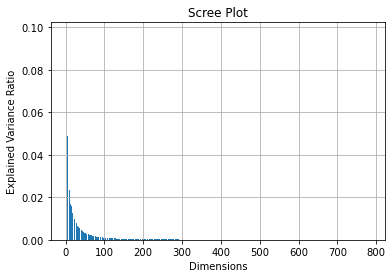

In [56]:
plt.bar([i for i in range(1,X.shape[1] + 1)],pca.explained_variance_ratio_)
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.title('Scree Plot')

# Choosing the right number of dimension
* We can choose the number of dimension that cumulative add upp to a large portion of the variance 

In [57]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
index = np.argmax(cumsum > 0.95) + 1 # return the index where cumulative sum is greater than 95
index

154

Text(0.5, 1.0, 'Explained Variance as a Function of Dimension')

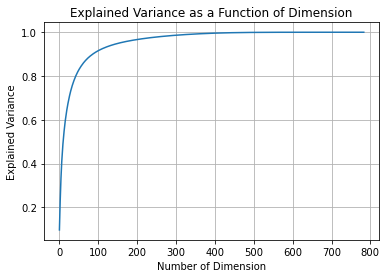

In [58]:
plt.plot([i for i in range(cumsum.shape[0])], cumsum)
plt.grid(True)
plt.xlabel('Number of Dimension')
plt.ylabel('Explained Variance')
plt.title('Explained Variance as a Function of Dimension')

In [59]:
pca = decom.PCA(n_components=0.95, svd_solver='full') # if n_components is a float between 0 and 1, it indicate the amount of variance to preserve 

X_reduced = pca.fit_transform(X)

In [60]:
X_reduced.size / 1000000

10.78

In [61]:
X_reduced.shape # it has 154 features rather than the inital 784 features

(70000, 154)

In [62]:
((X_reduced.size / 1000000) / (X.size / 1000000)) * 100
# the reduce dataset is only 19.6% of the original dataset while preserving 95% of the variance in the original dataset

19.64285714285714

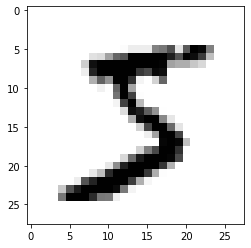

In [63]:
plt.imshow(X[0].reshape(28,28), cmap='binary')

# Incremental PCA
* The normal PCA and the Randomized PCA require the data to be fit in memory size in order for the algorithm to run 
* Hence very large dataset may have some issue running this algorithm
* Incremental PCA resolve this issue

In [64]:
incre_pca = decom.IncrementalPCA(n_components=154)
n_batches = 100
for X_batch in np.array_split(X, n_batches):
    incre_pca.partial_fit(X_batch)

X_reduced = incre_pca.transform(X)

# Kernel PCA
* Kernel PCA allow us to perform complex nonlinear projection for dimensionality reduction

In [70]:
X, y = dataset.make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
X.shape

(1000, 3)

In [71]:
px.scatter_3d(X, X[:,0], X[:,1], X[:,2])

In [72]:
rbf_pca = decom.KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)
X_reduced.shape

(1000, 2)

# Select Kernel and Hyperparameter
* As KPCA is a unsupervised learning technique, we can use GridSearch to determine the best kernel and hyperparameter values 
* We first create a pipeline to first reduce the dimension

In [73]:
clf = pipeline.Pipeline([
                    ('kpca', decom.KernelPCA(n_components=2)),
                    ('log_reg', lm.LogisticRegression())
                    ])

param_grid = [
    {'kpca__gamma': np.linspace(0.03,0.05,10),
     'kpca__kernel': ['rbf', 'sigmoid']
    }]

In [ ]:
grid_search_cv = ms.GridSearchCV(clf, param_grid, cv=3)
grid_search_cv.fit(X, y)